In [85]:
import numpy as np
import matplotlib.pyplot as plt
from getdist import plots, MCSamples
import getdist

In [100]:
def recta(x,param):
    return param[0]*x+param[1]

#Logaritmo natural del likelihood
def lnl(datos,modelo,param):
    '''
    logaritmo natural del likelihood. Se considera un likelihood con distribución normal.
    '''
    return -1/2*np.sum(((datos[1]-modelo(datos[0],param))/datos[2])**2)

def lnprior(param,extremos):
    '''
    logaritmo natural de prior. Se considera un prior PLANO donde todos los puntos del espacio de 
    parámetros tienen la misma probabilidad, y los puntos fuera del espacio se les asigna 0.
    
    param: arreglo con los parámetros.
    extremos: matriz tamaño 2 x len(param) en la que se encuentran los extremos inferior y superior a priori 
    de los parámetros, estos limitan un espacio de parámetros cuadrado, cúbico, etc.
    '''
    
    lnpr=np.zeros(len(param))
    for i in range(len(param)):
        if(extremos[i][0]<param[i]<extremos[i][1]):
            lnpr[i]=-1*np.log(1/(extremos[i][1]-extremos[i][0]))
        else:
            lnpr[i]=-1*np.inf
    return sum(lnpr)


def montecarlo(datos,modelo,desvp,pold,extremos,it,maxit):
    '''
    Esta función sirve para priors PLANOS
    
    datos: matriz que guarda los datos experimentales x, y y desviación de y
    modelo: modelo que se quiere ajustar a los datos
    desvp: desviación de distribución de la vecindad donde se buscarán nuevos puntos para iterar
    pold: primera aproximación
    extremos: límites inferiores y superiores (a priori) para cada paŕametro
    it: puntos aceptados deseados
    maxit: máximo de iteraciones permitidas
    '''
    cadena=[]
    lnpostold=lnl(datos,modelo,pold)+lnprior(pold,extremos)
    cadena.append(np.append(pold,lnpostold))
    nosus=0
    sus=0
    for i in range(maxit):
        random=np.random.randn(len(pold))
        pnew=desvp*random+pold        
        lnpostnew=lnl(datos,modelo,pnew)+lnprior(pnew,extremos)
        if(lnpostnew>lnpostold or np.exp(lnpostnew-lnpostold)>np.random.uniform()):
            cadena.append(np.append(pnew,lnpostnew))
            pold=pnew
            lnpostold=lnpostnew
            sus+=1
            if(sus==it):
                break
        else:
            cadena.append(np.append(pnew,lnpostnew)) #si queremos sólo los puntos aceptados comentamos esta línea
            nosus+=1
    return cadena,nosus

In [125]:
#Se generan valores para x,los parámetros,y y desvy
x=np.linspace(0,10,1000)
#param=(np.random.uniform(-1,1,2))      #para genrarlos aelatoriamente entre -1 y 1
param=[15,20]
y=recta(x,param)
desvy=np.full((len(y)), 0.1)

#arreglo de datos
datos=[x,y,desvy]

#desviación de distribución de la vecindad donde se buscarán nuevos puntos para iterar
#tanto en m como en b puse 0.5
desvp=np.full((len(param)), 0.1)

#primera aproximación de parámetros
aprox=([20,15],[20,25],[10,15],[10,25],[10,20])

#extremos a priori de los parámetros
extremos=([5,25],[10,30])

In [126]:
res=[]
for i in range(len(aprox)):
    res.append(montecarlo(datos,recta,desvp,aprox[i],extremos,10000,10000))

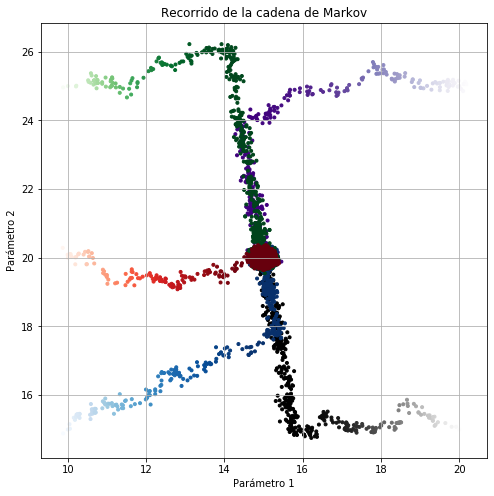

In [127]:
cmaps=['Greys','Purples', 'Blues', 'Greens', 'Reds']

fig,ax=plt.subplots(figsize=(8, 8))

for i in range(len(aprox)):
    ax.scatter(np.array(res[i][0])[:,0],np.array(res[i][0])[:,1],c=np.array(res[i][0])[:,2],cmap=cmaps[i],marker=".")

ax.set_xlabel('Parámetro 1')
ax.set_ylabel('Parámetro 2')
ax.set_title('Recorrido de la cadena de Markov') 
plt.grid()

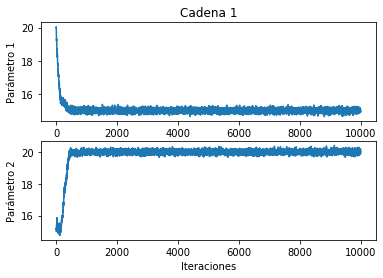

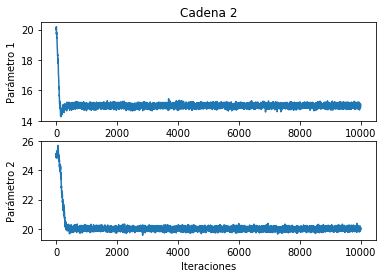

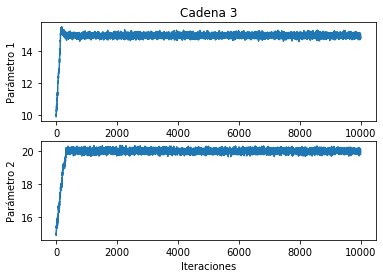

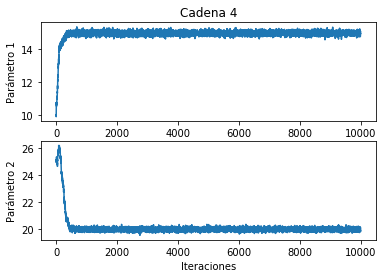

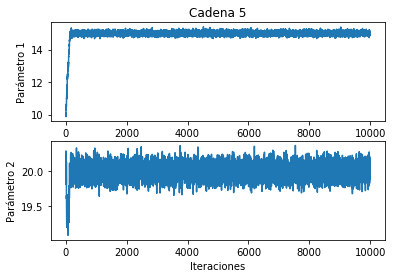

In [128]:
#Visualización del avance de cada parámetro en las 5 cadenas

for j in range(len(res)):
    fig, ax = plt.subplots(len(param))
    for i in range(len(param)):
        ax[i].plot(range(len(np.array(res[j][0])[:,i])),np.array(res[j][0])[:,i])
        ax[i].set_ylabel('Parámetro '+str(i+1))
    ax[i].set_xlabel('Iteraciones')
    ax[i-len(param)+1].set_title('Cadena '+str(j+1)) 

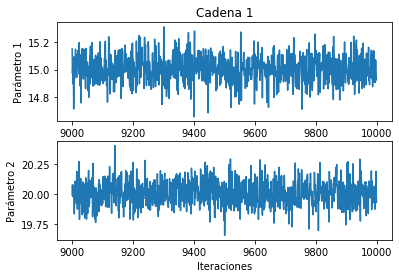

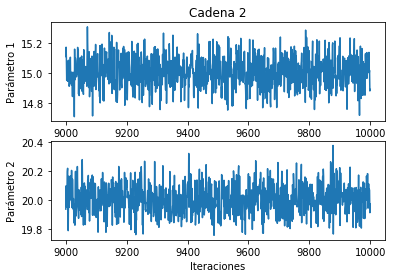

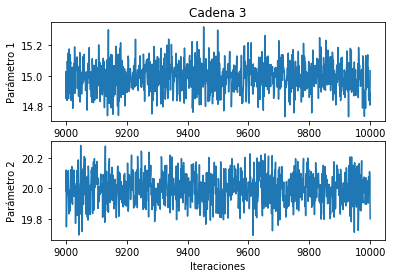

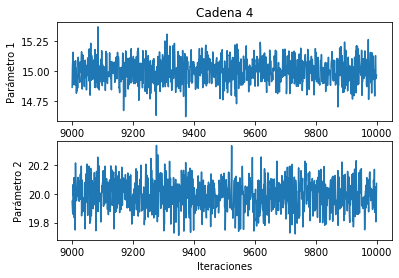

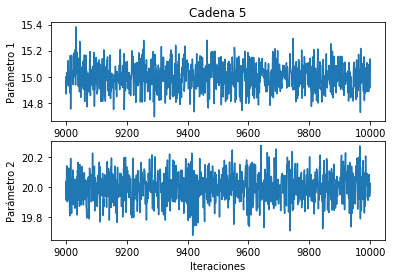

In [129]:
#Visualización de cada parámetro sin el burning

burn=1000
promediosc=np.zeros([5,2])

for j in range(len(res)):
    fig, ax = plt.subplots(len(param))
    for i in range(len(param)):
        ax[i].plot(range(len(np.array(res[j][0])[:,i])-burn-1,len(np.array(res[j][0])[:,i])),np.array(res[j][0])[len(np.array(res[j][0])[:,i])-1-burn:,i])
        ax[i].set_ylabel('Parámetro '+str(i+1))
        promediosc[j][i]=np.mean(np.array(res[j][0])[len(np.array(res[j][0])[:,i])-1-burn:,i])
    ax[i].set_xlabel('Iteraciones')
    ax[i-len(param)+1].set_title('Cadena '+str(j+1))

In [130]:
promediosc

array([[15.00494944, 20.00901576],
       [15.00876891, 20.00859351],
       [14.99396098, 19.99843915],
       [15.0001318 , 19.99203275],
       [14.99887946, 20.00172179]])

In [131]:
#Se unen cadenas sin burning en un solo arreglo
unioncadenas=[]
for i in range(len(res)):
    for j in range(len(res[i][0])-burn):
        unioncadenas.append(res[i][0][j+burn])
unioncadenas=np.array(unioncadenas)

Text(0.5, 1.0, 'Cadenas unidas')

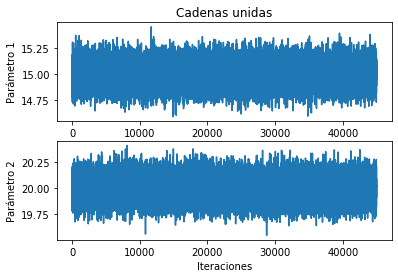

In [132]:
#Visualización de cada parámetro de la cadena unida

fig, ax = plt.subplots(len(param))
ax[0].plot(range(len(unioncadenas)),unioncadenas[:,0])
ax[1].plot(range(len(unioncadenas)),unioncadenas[:,1])
ax[0].set_ylabel('Parámetro 1')
ax[1].set_ylabel('Parámetro 2')
ax[1].set_xlabel('Iteraciones')
ax[0].set_title('Cadenas unidas')

In [133]:
#Cálculo de promedios de cada parámetro
promedios=(np.mean(unioncadenas[:,0]),np.mean(unioncadenas[:,1]))
promedios

(15.000100983679463, 19.99826649025511)

Removed no burn in


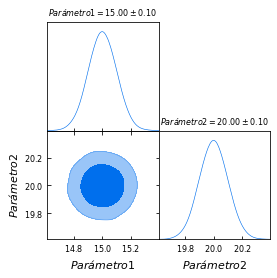

In [134]:
#Gráfica triangular
samples=MCSamples(samples=np.array(unioncadenas[:,(0,1)]),names=['x0','x1'],labels=['Parámetro 1','Parámetro 2'])
g = plots.get_subplot_plotter()
g.triangle_plot(samples, filled=True,title_limit=1)

In [135]:
#Criterio de convergencia de Gelman Rubin

def si2(cadena):
    '''
    Se introduce el arreglo de valores de la cadena de un solo parámetro sin burn
    '''
    media=np.mean(cadena)
    return 1/(len(cadena)-1)*np.sum((cadena-media)**2),media    

In [142]:
si2p1=np.zeros(len(res))
si2p2=np.zeros(len(res))
mediasp1=np.zeros(len(res))
mediasp2=np.zeros(len(res))

for i in range(len(res)):
    si2p1[i],mediasp1[i]=si2(np.array(res[i][0])[burn:,0])
    si2p2[i],mediasp2[i]=si2(np.array(res[i][0])[burn:,1])

s2p1=np.sum(si2p1)/len(res)
s2p2=np.sum(si2p2)/len(res)
bnp1=1/(len(res)-1)*np.sum((mediasp1-np.mean(mediasp1))**2)
bnp2=1/(len(res)-1)*np.sum((mediasp2-np.mean(mediasp2))**2)
sigmagorrop1=(len(np.array(res[i][0])[burn:,0])-1)/len(np.array(res[i][0])[burn:,0])*s2p1+bnp1
sigmagorrop2=(len(np.array(res[i][0])[burn:,0])-1)/len(np.array(res[i][0])[burn:,0])*s2p2+bnp2
Rp1=np.sqrt(sigmagorrop1/s2p1)
Rp2=np.sqrt(sigmagorrop2/s2p2)

print(f"R={Rp1} para el parámetro 1")
print(f"R={Rp2} para el parámetro 2")

R=1.0000071028581201 para el parámetro 1
R=1.0006614253303001 para el parámetro 2
